In [2]:
import numpy as np
import matplotlib.pyplot as plt
import vector
import pandas as pd
import lhapdf

In [29]:
# Cabbibo angle, from https://en.wikipedia.org/wiki/Cabibbo%E2%80%93Kobayashi%E2%80%93Maskawa_matrix
theta_c = 13.02 * np.pi/180 # radians
# Tau mass
mtau = 1.77682 # GeV
#
M_V = 0.84 # GeV
# difference between muon and electron magnetic moments (I think, see tau polarization paper)
xi = 3.706
# 
M_A = 1 # GeV
#
F_A_0 = -1.23
# Pion mass
m_pi = 0.139 # GeV

def spin_vector(tau4m, nu4m, nucleon4m, int_type: str):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    # I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
    Q2 = -q**2

    W = (p + q)**2
    x = Q2 / (2*p.dot(q)) # Björken scaling variable

    if int_type == "qel":
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    else:
        raise NotImplementedError("Only qel implemented")
    
    F = (
        (2*W1 + mtau**2 / M**2 * W4) * (Etau - ptau * costheta)
        + W2 * (Etau + ptau * costheta)
        + W3 / M * (Enu * Etau + ptau**2 - (Enu + Etau) * ptau * costheta)
        + mtau**2 / M * W5
    )

    return (
        # sx component, in the tau-nu plane
        -mtau*np.sin(theta)/2 *
        (2*W1 - W2 + Enu / M * W3 - mtau**2/M**2 * W4 + Etau/M * W5)
        / F,
        # sz component
        -1/2 * (
            (2*W1 - mtau**2 / M**2 * W4) * (ptau - Etau * costheta)
            + W2 * (ptau + Etau * costheta)
            + W3 / M * ((Enu + Etau) * ptau - (Enu * Etau + ptau**2) * costheta)
            - mtau**2 / M * W5 * costheta
        ) / F
    )

def spin_vector2(tau4m, nu4m, nucleon4m, int_type: str):
    M = nucleon4m.m
    ptau = tau4m.p
    Etau = tau4m.E
    theta = nu4m.deltaangle(tau4m)
    costheta = np.cos(theta)
    Enu = nu4m.E
    p = nucleon4m
    k = nu4m
    kprime = tau4m
    
    q = k - kprime # W boson 4-momentum
    # I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
    Q2 = -q**2
    assert np.all(Q2 > 0), Q2

    W2 = (p + q)**2
    assert np.all(W2 > 0), W2
    
    x = Q2 / (2*p.dot(q)) # Björken scaling variable
    print(x, Q2/(W2+Q2-M**2), W2, M**2)
    
    if int_type == "qel":
        x = 1
        W1 = W1qel(x, Q2, p, q, M)
        W2 = W2qel(x, Q2, p, q, M)
        W3 = W3qel(x, Q2, p, q, M)
        W4 = W4qel(x, Q2, p, q, M)
        W5 = W5qel(x, Q2, p, q, M)
    else:
        raise NotImplementedError("Only qel implemented")
    
    R = (
        (Etau - ptau * costheta) / M * (W1 + mtau / (2*M**2)*W4)
        + (Etau + ptau * costheta) / (2*M) * W2
        + ((Enu + Etau) / M * (Etau - ptau * costheta) / (2*M) - mtau**2 / (2*M**2)) * W3
        - mtau**2 / (2*M) * W5
    )

    return (
        # sz component
        mtau * np.sin(theta) / (2*M*R) * (
            -(2*W1 - W2 - mtau**2/M**2 * W4 + Etau/M * W5) - Enu / M * W3 # X in lepton polarization paper, eq 7a
        ),
        # sx component, in the tau-nu plane
        -1 + mtau**2/(M**2 * R) * (
            (2*M/(Etau + ptau) * W1 + (Etau - ptau) / (Etau + ptau) * W3) * np.cos(theta/2)**2
            + (M/(Etau + ptau) * W2 + (Etau + ptau) / M * W4 - W5) * np.sin(theta/2)**2
        ),
    )

def w(p, q, M):
    return p.dot(q)/M**2

def G_V_E(q):
    return 1 / (1-q**2/M_V**2)**2

def G_V_M(q):
    return (1+xi) / (1-q**2/M_V**2)**2

def F_V(q, M):
    return (G_V_E(q) - q**2 / (4*M**2) * G_V_M(q)) / (1 - q**2 / (4*M**2))

def F_A(q):
    return F_A_0 / (1 - q**2 / M_A**2)**2

def F_M(q, M):
    return (G_V_M(q) - G_V_M(q)) / (xi * (1 - q**2 / (4*M**2)))

def F_T(q):
    return 0

def F_S(q):
    return 0

def F_p(q, M):
    return 2*M**2 * F_A(q) / (m_pi**2 - q**2)

def Wqel_coefficient(x, Q2, p, q, M):
    # assert np.isclose(x, 1), x  # a delta function here where x must be 1
    return np.cos(theta_c)**2 * 1/w(p, q, M) 

def W1qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * (F_A(q)**2 + xprime * (F_A(q)**2 + (F_V(q, M) + F_M(q, M))**2))
    )

def omega_2(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return F_V(q, M)**2 + F_A(q)**2 + xprime * (F_M(q, M)**2 + 4*F_T(q)**2)

def W2qel(x, Q2, p, q, M):
    # assert np.isclose(x, 1), x
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * omega_2(x, Q2, p, q, M)
    )

def W3qel(x, Q2, p, q, M):
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * -2 * np.real(np.conj(F_A(q)) * (F_V(q, M) + F_M(q, M)))
    )

def W4qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        # omega_4
        * (
            np.real(np.conj(F_V(q, M)) * (F_S(q) - 1/2 * F_M(q, M)) - np.conj(F_A(q)) * (F_T(q) + F_p(q, M)))
            + xprime * (1/2 * (F_M(q, M) - F_S(q))**2 + (F_T(q) + F_p(q, M))**2)
            - 1/4* (1+xprime) * F_M(q, M)**2 + (1+1/2 * xprime) * F_S(q)**2
        )
    )

def W5qel(x, Q2, p, q, M):
    xprime = Q2 / (4*M**2)
    return (
        Wqel_coefficient(x, Q2, p, q, M)
        * (
            2 * np.real(np.conj(F_S(q)) * (F_V(q, M) - xprime*F_M(q, M)) - np.conj(F_T(q)) * (F_A(q) - 2*xprime*F_p(q, M)))
            + omega_2(x, Q2, p, q, M)
        )
    )

# Resonance scattering
# Delta mass
M_delta = 1.232 # GeV
# Delta width assuming dominance of S-waves
Gamma_delta = 0.12 # GeV
# Is 2 if the Delta produced is Delta++ (interaction with p), 
# and 2/3 if the Delta produced is Delta+ (interaction with n). 
# Maybe take average, since there are equally many n and p in Oxygen?
kappa = 2

# def W1res(x, Q2, p, q, M):
#     return (
#         kappa * np.cos(theta_c)**2 * M * M_delta * 
#         eta_delta_bw(W)**2 * 
#         sum(
#             V_1(x, Q2, j, k) * C_V(x, Q2, j) * C_V(x, Q2, k) 
#             + A_1(x, Q2, j, k) * C_A(x, Q2, j) * C_A(x, Q2, k) 
#             for j, k in itertools.product(range(3, 7), repeat=2)
#         )
#     )

# Deep inelastic scattering
# The PDFs used in GENIE seems to bee CT10nlo, member 0 from LHAPDF. Source: https://github.com/GENIE-MC/Generator/blob/master/config/LHAPDF6.xml
# I should therefore probably use the same here
def pdf(quark, x, Q2):
    p = lhapdf.mkPDF("CT10nlo", 0)
    return p.xfxQ2(quark, x, Q2)


def mass_corrected_xi(Q2, x, quark):
    if quark != 4:
        return x
    
    m_charm = 1.27 # GeV
    return x / (Q2 / (Q2 + m_charm**2))

def W1dis(x, Q2, p, q, M):
    return (
        # (1 + x/w(p, q, M)) * # Correction, see eq. 55 in tau polarization paper. Might not be completely correct since only x is used instead of xi. Unclear notation in paper
        sum(pdf(quark, x, Q2) for quark in [*range(1, 7), *range(-6, 0)]) # F1
    )

def W2dis(x, Q2, p, q, M):
    return (
        1/w(p, q, M) 
        * 2 * sum(x * pdf(quark, x, Q2) for quark in [*range(1, 7), *range(-6, 0)]) # F2
    )

def W3dis(x, Q2, p, q, M):
    return 2 * (
        sum(pdf(quark, x, Q2) for quark in range(1, 7))
        - sum(pdf(quark, x, Q2) for quark in range(-6, 0))
    )

def W4dis(x, Q2, p, q, M):
    return 0

def W5dis(x, Q2, p, q, M):
    # In the tau polarization paper, there is a factor of 2 in front. 
    # I am not sure if this is a mistake, convention difference, or something else
    return W1dis(x, Q2, p, q, M)

In [30]:
particle_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_particles.csv")
event_info = pd.read_csv("../data/test_genie_NuTau_10.0_GeV_event_info.csv")

qel_particles = particle_info[
    particle_info["event_num"]
    .isin(event_info.loc[event_info["qel"], "event_num"].values)
]
taus = qel_particles[qel_particles["pdg"] == 15]
tau_angles = np.arctan(np.sqrt(taus["px"]**2 + taus["py"]**2) / taus["pz"])

In [31]:
nutaus = qel_particles.groupby("event_num").nth(1).reset_index(drop=True)
assert (nutaus["pdg"] == 16).all()
taus = qel_particles.groupby("event_num").nth(2).reset_index(drop=True)
assert (taus["pdg"] == 15).all()

nutau4m = vector.array({"E": nutaus["E"], "px": nutaus["px"], "py": nutaus["py"], "pz": nutaus["pz"]})
tau4m = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})
q = nutau4m - tau4m
assert ((q["E"]**2 - q["px"]**2 - q["py"]**2 - q["pz"]**2) < 0).all()
assert np.all((q**2) < 0)

In [17]:
nucleon4m = vector.array({"E": [0.983], "px": [0], "py": [0], "pz": [0]})
nu4m = vector.obj({"E": [10], "px": [0], "py": [0], "pz": [10]})

In [32]:
zero_angle_tau = taus.values[np.argmin(tau_angles)]
tau4m = vector.array({"E": [zero_angle_tau[2]], "px": [zero_angle_tau[3]], "py": [zero_angle_tau[4]], "pz": [zero_angle_tau[5]]})
s = np.array(spin_vector2(tau4m, nu4m, nucleon4m, "qel"))

# The polarization (second term) should be slightly below 1 (center left panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be very close to -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

[0.28255295] [0.28255295] [1.12268233] 0.966289


(array([[-0.00138453],
        [-0.96827551]]),
 0.9682765003697137,
 array([-0.99999898]))

In [24]:
s = np.array(spin_vector(tau4m, nu4m, nucleon4m, "qel"))
# The polarization (second term) should be slightly less than 1
# See center left panel, figure 6 in tau polarization paper
s, np.linalg.norm(s)*2

(array([[-0.00052932],
        [-0.31253993]]),
 0.6250807503084903)

The values above are really good and close to what they should be. Let us now check $\theta = 5^\circ, 10^\circ$, since these are reproduced in the paper as well.

In [25]:
almost5deg = np.abs(tau_angles * 180/np.pi - 5).argmin()
tau_angles.values[almost5deg] * 180/np.pi

5.000498804220101

In [26]:
tau5deg = taus.iloc[almost5deg, :].values
s = np.array(
    spin_vector2(
        vector.array({"E": [tau5deg[2]], "px": [tau5deg[3]], "py": [tau5deg[4]], "pz": [tau5deg[5]]}), 
        nu4m, 
        nucleon4m, 
        "qel"
    )
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

[0.56920949]
[0.81574152] [0.81574152] [1.17605235] 0.966289


(array([[-0.20777652],
        [-0.97365862]]),
 0.9955813279072329,
 array([-0.97797999]))

In [27]:
almost10deg = np.abs(tau_angles * 180/np.pi - 10).argmin()
tau10deg = taus.iloc[almost10deg, :].values
s = np.array(
    spin_vector2(
        vector.array({"E": [tau10deg[2]], "px": [tau10deg[3]], "py": [tau10deg[4]], "pz": [tau10deg[5]]}), 
        nu4m, 
        nucleon4m, 
        "qel"
    )
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

[5.47767864]
[0.50385128] [0.50385128] [6.40177547] 0.966289


(array([[-0.53390058],
        [-0.71210957]]),
 0.8900280142518681,
 array([-0.80009793]))

In [28]:
s = spin_vector2(
    vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]}), 
    nu4m, 
    nucleon4m, 
    "qel"
)

# The polarization (second term) should be closer to 1 (center center panel, fig 6 in tau polarization paper)
# The polarization angle cos(theta_p) (third term) should be slightly above -1 (bottom center panel, fig 6 in tau polarization paper)
s, np.linalg.norm(s), s[1] / np.linalg.norm(s)

[0.39316318 0.34998314 0.23513376 ... 2.31889019 0.189363   0.27749383]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

MomentumNumpy4D([(0.00182877, -0.00117105, 9.72818804, 9.88912213)],
                dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('t', '<f8')])

(0.0, 2.0)

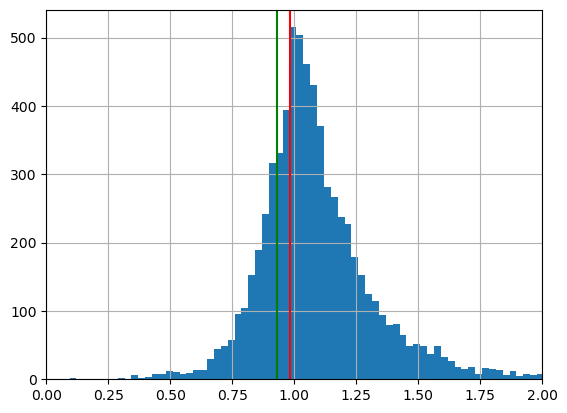

In [41]:
p = nucleon4m
k = nu4m
kprime = vector.array({"E": taus["E"], "px": taus["px"], "py": taus["py"], "pz": taus["pz"]})

q = k - kprime # W boson 4-momentum
# I might also pass this as a parameter. Though probably not, since the model assumes that it is a nucleon, not a nucleus.
Q2 = -q**2

W2 = (p + q)**2
plt.hist(W2, bins=300)
plt.grid()
plt.axvline(0.983, color="red")
plt.axvline(14.895082 / 16, color="green")
plt.xlim(0, 2)

In [176]:
import uproot

with uproot.open("../data/gntp.2.gst.root") as f:
    tree = f["gst"]
    qel = tree["qel"].array()
    cc = tree["cc"].array()
    mask = qel & cc
    taus = {"E": tree["El"].array()[mask], "px": tree["pxl"].array()[mask], "py": tree["pyl"].array()[mask], "pz": tree["pzl"].array()[mask]}
    Q2 = tree["Q2"].array()[mask]
    W = tree["W"].array()[mask]
    Ev = tree["Ev"].array()[mask]

In [177]:
(-(
    vector.array({
        "E": np.ones(len(taus["E"])) * Ev[0], 
        "px": np.zeros(len(taus["E"])), "py": np.zeros(len(taus["E"])), 
        "pz": np.ones(len(taus["E"])) * Ev[0]})
    - vector.array(taus)
)**2 - Q2)

<Array [0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0] type='83403 * float64'>

In [173]:
Q2

<Array [0.606, 0.9, 0.202, ..., 1.26, 0.637, 1.38] type='83403 * float64'>

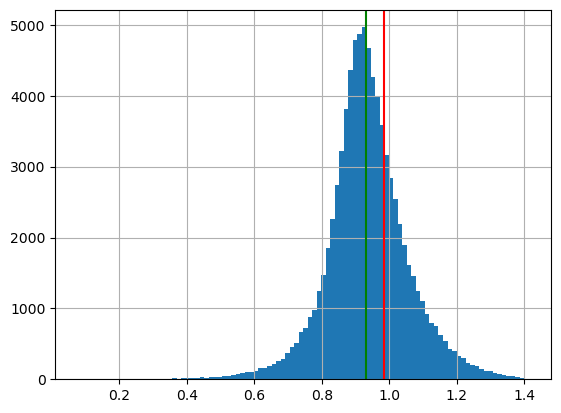

In [147]:
plt.hist(W, bins=100)
plt.grid()
plt.axvline(0.983, c="r")
plt.axvline(14.895082 / 16, c="g")